In [1]:
### Prepare the workbook
import numpy
import pandas as pd
import pyfolio as pf
#import tushare as ts
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model



%matplotlib inline

In [2]:
#### function: get Patterns with specified nr of days lookingback
def get_patterns(n, ret) :
    signals = pd.DataFrame()
    scores = [];
    for i in range(n) :
        signals[i] = (ret.shift(n-i-1) > 0) * 1
        if (i == 0) :
            scores = signals[i];
        else :
            scores = scores + signals[i] * pow(2, i);
    return scores;

def get_patterns1(n, ret) :
    signals = pd.DataFrame();
    scores = [];
    for i in range(0, n) :
        signals[i] = 2*(ret.shift(n - i-1) > 0.0075)
        signals[i] = signals[i] + 1*((ret.shift(n - i - 1) > -0.0075) & (signals[i] != 2))
        if (i == 0) :
            scores = signals[i];
        else :
            scores = scores + signals[i] * pow(3, i);
    return scores;

reading data

In [3]:
data = pd.read_csv('../../data/index_shanghai.csv', index_col='date', parse_dates=True)
data = data['19950101'::]
#data = pd.read_excel('../../data/500ETF_510500_1d_20151028.xlsx', index_col='date', parse_dates=True)

#### Return calculation
ret_cc = data['close'] / data['close'].shift(1) - 1
ret_co = data['close'] / data['open'] - 1
ret_oc = data['open'] / data['close'].shift(1) - 1
data['ret_cc'] = ret_cc;
data['ret_co'] = ret_co;
data['ret_oc'] = ret_oc;
ret_all = data.ix[:, ('ret_cc', 'ret_co', 'ret_oc')]

### cleaning
data = data.dropna()

In [4]:
len(data)

5022

In [17]:
ret = data['ret_cc']
#ret = ret.ix[2000:3000]
n = 5
annualized_factor = 365

### function: get patterns, and calculate the historical insample returns, sharpe ratios and 
### other risk measures for each pattern. 
def pattern_characters(n, ret, annualized_factor=365) :
    pattern = get_patterns(n, ret)
    ret_pattern = pd.DataFrame(pattern.shift(1), columns=['pattern']).join(ret)
    ret_pattern_grouped = ret_pattern.groupby('pattern')

    nr_group = ret_pattern_grouped.count().shape[0]
    counts = {}
    probs = {}
    profit_factor = {}
    sharpes = {}
    for i in range(nr_group) :
        ret_test = ret_pattern_grouped.get_group(i).ix[:, 1]
        counts[i] = len(ret_test)
        probs[i] = sum(ret_test > 0) / counts[i]
        profit_factor[i] = sum(ret_test[ret_test > 0]) / sum(-ret_test[ret_test < 0])
        sharpes[i] = numpy.mean(ret_test) / numpy.std(ret_test) * numpy.sqrt(annualized_factor)
    prob_list = pd.DataFrame(pd.Series(counts, name='count'), index = range(nr_group))
    prob_list = prob_list.join(pd.Series(probs, name='win_rate'))
    prob_list = prob_list.join(pd.Series(profit_factor, name='profit_factor'))
    prob_list = prob_list.join(pd.Series(sharpes, name='sharpes'))
    
    return prob_list

### function: determine the best trading strategy, based on the pattern,and its historical risk measure
def optimize_returns(n, ret, prob_list) :
    n_total = len(ret)
    patterns = get_patterns(n, ret);
    ret_patterns = pd.DataFrame(patterns.shift(1), columns=['patterns']).join(ret)
    
    signal = pd.Series(0, index=ret_patterns.index)
    for i in range(n_total) :
        pattern = ret_patterns['patterns'].ix[i]
        if numpy.isnan(pattern):
            sharpe = 0;
            win_ratio = 0;
        else :
            sharpe = prob_list['sharpes'].ix[pattern]
            win_ratio = prob_list['win_rate'].ix[pattern]
        if ( win_ratio > 0.55) :
            signal[i] = 1
        elif (win_ratio < 0.45) :
            signal[i] = -1
        else:
            signal[i] = 0
        #signal[i] = sharpe
    #print(ret_patterns.ix[:, 1])      
    ret_strategy = ret_patterns.ix[:, 1] * pd.Series(signal, index=ret_patterns.index)
    return ret_strategy

### Out of Sample (OOS) test 
Here is the oos test function for the strategy. We implemented 3 types of OOS
1. fixed lookback period (in sample), the rest of the data goes to oos test
2. Insample window has a fixed starting point ( at 0) and sliding. The oos window is defined as n_sliding
3. 

In [18]:
### function: 3 types of out-of-sample test for the pattern trading
def strategy_oos_test(n, ret, type = 1, n_lookback = 0, n_sliding = 0) :
    n_total = len(ret)
    ret_oos = pd.DataFrame();
    
    ## type = 1: single train set defined by n_lookback, single test set from n_lookback:n_total
    if type == 1 or type == 0:
        ret_train = ret[0:(n_lookback - 1)]
        ret_test = ret[n_lookback::]

        prob_list = pattern_characters(n, ret_train)
        ret_strategy = optimize_returns(n, ret_test, prob_list)
        ret_oos['t1'] = ret_strategy
        #(1+ret_strategy).cumprod().plot()
    ## type 2: sliding insample window, defined by n_lookback and sliding forward. The test set window is defined as n_      
    if type == 2 or type == 0:
        k = n_lookback
        ret_strategy = pd.Series()
        while k < n_total-1 :
            ret_train = ret[0:(k - 1)]
            if (k+n_sliding) <= n_total :
                k2 = k + n_sliding - 1
            else :
                k2 = n_total - 1
            ret_test = ret[k:k2]

            ## trading
            prob_list = pattern_characters(n, ret_train)
            ret_strategy = ret_strategy.append(optimize_returns(n, ret_test, prob_list))
            k = k2;
        ret_oos['t2'] = ret_strategy
        #(1+ret_strategy).cumprod().plot()
    ## type 3: sliding insample window, defined by n_lookback and sliding forward. The test set window is defined as n_      
    if type == 3 or type == 0:
        k = n_lookback
        ret_strategy = pd.Series()
        while k < n_total-1 :
            ret_train = ret[(k-n_lookback):(k - 1)]
            if (k+n_sliding) <= n_total :
                k2 = k + n_sliding - 1
            else :
                k2 = n_total - 1
            ret_test = ret[k:k2]

            ## trading
            prob_list = pattern_characters(n, ret_train)
            ret_strategy = ret_strategy.append(optimize_returns(n, ret_test, prob_list))
            k = k2;
        ret_oos['t3'] = ret_strategy
        #(1+ret_strategy).cumprod().plot()
        
    return ret_oos;

now we use the out-of-sample test , to show how the performance can be using pattern to trade. 

/Applications/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:1186: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point
  self._convert_scalar_indexer(key, axis)
/Applications/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:81: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point
  return self.obj[label]


{1: 0.36424664346096469, 2: 0.25733465937344607, 3: 0.3167578319244157}

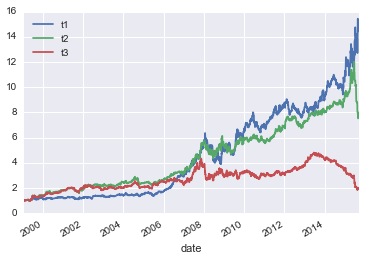

In [21]:
n=5
n_lookback = 1000
n_sliding = 100
ret_oos = strategy_oos_test(n, ret, 0, n_lookback, n_sliding)
(1+ret_oos).cumprod().plot()

winrate = {}
winrate[1] = sum(ret_oos.t1>0) / len(ret_oos.t1)
winrate[2] = sum(ret_oos.t2 > 0) / len(ret_oos.t2)
winrate[3] = sum(ret_oos.t3 > 0) / len(ret_oos.t3)
winrate

In [22]:
prob_list = pattern_characters(5, ret)
prob_list

,count,win_rate,profit_factor,sharpes
0,127,0.511811,1.111484,0.700578
1,150,0.566667,1.084951,0.528594
2,150,0.506667,0.997335,-0.016039
3,135,0.437037,0.804250,-1.472817
4,143,0.482517,0.974785,-0.169352
5,144,0.472222,0.669468,-2.511056
6,169,0.532544,1.416649,2.460804
7,130,0.569231,1.477969,2.712338
8,147,0.489796,0.974658,-0.154744
9,146,0.534247,0.900906,-0.717268


In [8]:
(prob_list)
(1+ret_cc[1000::]).cumprod().plot()

NameError: name 'prob_list' is not defined

## Testing Optunity Parameter Optimization Algorithm

In [ ]:
# comment this line when running the notebook yourself
%matplotlib inline

import math
import optunity
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
def objective_fun_strategy(ret, n, long_sharpe, short_sharpe, long_win_rate, short_win_rate):
    n = int(n)
    prob_list = pattern_characters(n, ret)
    
    def optimize_returns(n, ret, prob_list, long_sharpe, short_sharpe, long_win_rate, short_win_rate) :
        n_total = len(ret)
        patterns = get_patterns(n, ret);
        ret_patterns = pd.DataFrame(patterns.shift(1), columns=['patterns']).join(ret)

        signal = pd.Series(0, index=ret_patterns.index)
        for i in range(n_total) :
            pattern = ret_patterns['patterns'].ix[i]
            if numpy.isnan(pattern):
                sharpe = 0;
                win_ratio = 0;
            else :
                sharpe = prob_list['sharpes'].ix[pattern]
                win_ratio = prob_list['win_rate'].ix[pattern]
            if (sharpe > long_sharpe and win_ratio > long_win_rate) :
                signal[i] = 1
            elif (sharpe < short_sharpe and win_ratio < short_win_rate) :
                signal[i] = -1
            else:
                signal[i] = 0
            #signal[i] = sharpe
        #print(ret_patterns.ix[:, 1])      
        ret_strategy = ret_patterns.ix[:, 1] * pd.Series(signal, index=ret_patterns.index)
        return ret_strategy
    ret_strategy = optimize_returns(n, ret_test, prob_list)
    return

In [ ]:
### function: determine the best trading strategy, based on the pattern,and its historical risk measure

### Case1: 上证指数

In [ ]:
data = pd.read_csv('../../data/index_shanghai.csv', index_col='date', parse_dates=True)
data = data['19950101'::]
#data = pd.read_excel('../../data/500ETF_510500_1d_20151028.xlsx', index_col='date', parse_dates=True)

#### Return calculation
ret_cc = data['close'] / data['close'].shift(1) - 1
ret_co = data['close'] / data['open'] - 1
ret_oc = data['open'] / data['close'].shift(1) - 1
data['ret_cc'] = ret_cc;
data['ret_co'] = ret_co;
data['ret_oc'] = ret_oc;
ret_all = data.ix[:, ('ret_cc', 'ret_co', 'ret_oc')]

### cleaning
data = data.dropna()


### capture the pattern
pattern = get_patterns(3, data['ret_cc'])
ret_pattern = pd.DataFrame(pattern.shift(1), columns=['pattern']).join(ret_all)
#ret_pattern = ret_pattern[~numpy.isnan(ret_pattern['pattern'])]
ret_pattern_grouped = ret_pattern.groupby('pattern')

### data to test
nr_group = ret_pattern_grouped.count().shape[0]
plt.figure(figsize=(12,10),dpi=98)
for i in range(nr_group) :
    plt.subplot(3,3,i+1)
    ret_test = ret_pattern_grouped.get_group(i).ix[:, 1]
    plt.plot(ret_test.cumsum())

In [ ]:
ret_

In [ ]:
pattern = get_patterns(1, data['ret_co'])
ret_pattern = pd.DataFrame(pattern.shift(1), columns=['pattern']).join(ret_all)
ret_pattern_grouped = ret_pattern.groupby('pattern')
ret_pattern_grouped.get_group(0)

In [ ]:
ret_strategy = data['ret_cc'] * 0;
ret_strategy = pd.DataFrame.merge(ret_strategy, ret_pattern_grouped.get_group(6).ix[:,1])
ret_strategy[numpy.isnan(ret_strategy) ]  = 0
ret_strategy = ret_strategy + ret_pattern_grouped.get_group(4).ix[:,1]
ret_strategy[numpy.isnan(ret_strategy)] = 0

#ret_strategy = pd.DataFrame.merge((data['ret_cc']*0), ret_pattern_grouped.get_group(6).ix[:,1], how='outer')
#ret_pattern_grouped.get_group(4).ix[:,1]
#pf.create_returns_tear_sheet(ret_strategy, benchmark_rets=data['ret_cc'])

In [ ]:
pd.DataFrame.merge?

In [ ]:
pd.

### 测试中证500 IC期货和指数投资

In [ ]:
### loading data
data = pd.read_excel('../../data/IC500_CurrentMonth_20151027.xlsx', index_col='date', parse_dates=True)
data_future = data.ix[:,0:7]
data_index = data.ix[:, 8:]

### calculate returns of the indicies
ret_index_cc = data['bm_close'] / data['bm_close'].shift(1) - 1
ret_index_co = data['bm_close'] / data['bm_open'] - 1
ret_index_oc = data['bm_open'] / data['bm_close'].shift(1) - 1
ret_index_all = pd.DataFrame()
ret_index_all['cc'] = ret_index_cc
ret_index_all['co'] = ret_index_co
ret_index_all['oc'] = ret_index_oc
ret_index_all = ret_index_all.dropna()

### calculate returns of the future
ret_future_cc = data['fu_close'] / data['fu_close'].shift(1) - 1
ret_future_co = data['fu_close'] / data['fu_open'] - 1
ret_future_oc = data['fu_open'] / data['fu_close'].shift(1) - 1
ret_future_all = pd.DataFrame()
ret_future_all['cc'] = ret_future_cc
ret_future_all['co'] = ret_future_co 
ret_future_all['oc'] = ret_future_oc
ret_future_all = ret_future_all.dropna()

In [ ]:
### capture the pattern
pattern = get_patterns(1, ret_index_all['co'])
ret_pattern = pd.DataFrame(pattern.shift(1), columns=['pattern']).join(ret_future_all)
ret_pattern = ret_pattern[~numpy.isnan(ret_pattern['pattern'])]
ret_pattern_grouped = ret_pattern.groupby('pattern')

### data to test
nr_group = ret_pattern_grouped.count().shape[0]
plt.figure(figsize=(12,10),dpi=98)
for i in range(0, nr_group) :
    plt.subplot(3,3,i+1)
    ret_test = ret_pattern_grouped.get_group(i)
    plt.plot(ret_test.cumsum())

ret_pattern_grouped

In [ ]:
pf.create_full_tear_sheet(ret_pattern_grouped.get_group(1).ix[:, 2], benchmark_rets=ret_future_all['cc'])